In [0]:
# Imports here
import matplotlib.pyplot as plt
import seaborn as sb

#%reload_ext autoreload        <------------— comment out 
#%autoreload 0                 <------------— comment out
%matplotlib inline
%config InlineBackend.figure_format = 'retina'


from __future__ import print_function, division


import torch
import torch.nn as nn
import torchvision.models as models

import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets,transforms, models
import matplotlib.pyplot as plt
import time

import copy
from PIL import Image
import json
from collections import OrderedDict

import math

plt.ion() 


from torch.autograd import Variable

from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader


from PIL import Image,ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

from tqdm import tqdm
import numpy as np
from glob import glob
import os
import json

import seaborn as sns
import pandas as pd
import numpy as np

import cv2                

import matplotlib.pyplot as plt                        
%matplotlib inline

# Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Write your Algorithm
* [Step 6](#step6): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

Make sure that you've downloaded the required human and dog datasets:
* Download the [dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip).  Unzip the folder and place it in this project's home directory, at the location `/dogImages`. 

* Download the [human dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip).  Unzip the folder and place it in the home diretcory, at location `/lfw`.  

*Note: If you are using a Windows machine, you are encouraged to use [7zip](http://www.7-zip.org/) to extract the folder.*

In the code cell below, we save the file paths for both the human (LFW) dataset and dog dataset in the numpy arrays `human_files` and `dog_files`.

In [0]:
import numpy as np
from glob import glob

# load filenames for human and dog images
human_files = np.array(glob("lfw/*/*"))
dog_files = np.array(glob("dogImages/*/*/*"))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 13233 total human images.
There are 8351 total dog images.


<a id='step1'></a>
## Step 1: Detect Humans

In this section, we use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.  In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


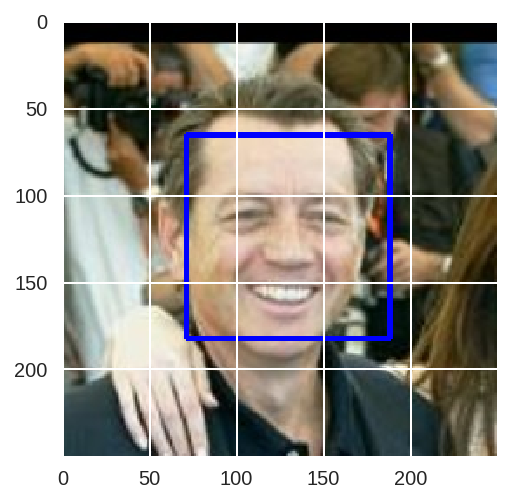

In [0]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
#face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[0])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [0]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 
(You can print out your results and/or write your percentages in this cell)

In [0]:
from tqdm import tqdm

human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

#-#-# Do NOT modify the code above this line. #-#-#

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.

n_detected_humans_faces_in_human_files = 0
n_detected_humans_faces_in_n_dog_files = 0

for f in range(100):
    if face_detector(human_files_short[f]):
        n_detected_humans_faces_in_human_files += 1
    if face_detector(dog_files_short[f]):
        n_detected_humans_faces_in_n_dog_files +=1
        
print("Detected human faces in human files: {}%. \n Detected human faces in in dogs files: {}%.".format(n_detected_humans_faces_in_human_files, n_detected_humans_faces_in_n_dog_files))

Detected human faces in human files: 98%. 
 Detected human faces in in dogs files: 6%.


We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [0]:
### (Optional) 
### TODO: Test performance of anotherface detection algorithm.
### Feel free to use as many code cells as needed.

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to detect dogs in images.  

### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  

In [0]:
import torch
import torchvision.models as models

# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:07<00:00, 72628551.22it/s]


Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

### (IMPLEMENTATION) Making Predictions with a Pre-trained Model

In the next code cell, you will write a function that accepts a path to an image (such as `'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model.  The output should always be an integer between 0 and 999, inclusive.

Before writing the function, make sure that you take the time to learn  how to appropriately pre-process tensors for pre-trained models in the [PyTorch documentation](http://pytorch.org/docs/stable/torchvision/models.html).

In [0]:
from PIL import Image
import torchvision.transforms as transforms

def VGG16_predict(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    
    ## TODO: Complete the function.
    ## Load and pre-process an image from the given img_path
    ## Return the *index* of the predicted class for that image
    
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
    
    transform = transforms.Compose([transforms.Resize(224),
                                    transforms.CenterCrop((224,224)),
                                    transforms.ToTensor(),
                                    normalize])
                                    
    image = Image.open(img_path)
    image = transform(image)
    image = image.unsqueeze_(0)
    
    if use_cuda:
        image = image.cuda()

    VGG16.eval()
    
    output = VGG16(image).cpu()
    
    index = output.data.numpy().argmax()
    
    return index # predicted class index

### (IMPLEMENTATION) Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only check if the pre-trained model predicts an index between 151 and 268 (inclusive).

Use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [0]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    ## TODO: Complete the function

    return (VGG16_predict(img_path) in range(151,269))
    

### (IMPLEMENTATION) Assess the Dog Detector

__Question 2:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 


In [0]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.

n_detected_dogs_in_human_files = 0
n_detected_dogs_in_n_dog_files = 0

for f in range(100):
    if dog_detector(human_files_short[f]):
        n_detected_dogs_in_human_files += 1
    if dog_detector(dog_files_short[f]):
        n_detected_dogs_in_n_dog_files +=1
        
print("Detected dogs in human files: {}%. \n Detected dogs in in dogs files: {}%.".format(n_detected_dogs_in_human_files, n_detected_dogs_in_n_dog_files))

Detected dogs in human files: 1%. 
 Detected dogs in in dogs files: 100%.


We suggest VGG-16 as a potential network to detect dog images in your algorithm, but you are free to explore other pre-trained networks (such as [Inception-v3](http://pytorch.org/docs/master/torchvision/models.html#inception-v3), [ResNet-50](http://pytorch.org/docs/master/torchvision/models.html#id3), etc).  Please use the code cell below to test other pre-trained PyTorch models.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [0]:
### (Optional) 
### TODO: Report the performance of another pre-trained network.
### Feel free to use as many code cells as needed.

---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 10%.  In Step 4 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have trouble distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively).  You may find [this documentation on custom datasets](http://pytorch.org/docs/stable/torchvision/datasets.html) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [0]:
import os
from torchvision import datasets

data_dir = '/content/dogImages'

batch_size=16 


#  Define transforms for the training and validation sets
data_transforms = {
    'train': transforms.Compose([transforms.RandomRotation(30),
                                     transforms.RandomResizedCrop(224),
                                     transforms.RandomHorizontalFlip(),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406],
                                                          [0.229, 0.224, 0.225])
                                     ]),
    'valid': transforms.Compose([transforms.Resize(256),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406],
                                                          [0.229, 0.224, 0.225])
                                     ]),
    'test': transforms.Compose([transforms.Resize(256),
                                    transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406],
                                                         [0.229, 0.224, 0.225])
                                    ]),
}

#  Load the datasets with ImageFolder
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'valid', 'test']}


dataloaders = {
    'train': torch.utils.data.DataLoader(image_datasets['train'], batch_size=batch_size, shuffle=True ),
    'valid': torch.utils.data.DataLoader(image_datasets['valid'], batch_size=batch_size, shuffle=True),
    'test': torch.utils.data.DataLoader(image_datasets['test'], batch_size=batch_size, shuffle=True)
}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid', 'test']}

print("Size of training set is: "+str(dataset_sizes['train']))
print("Size of validation set is: "+str(dataset_sizes['valid']))
print("Size of testing set is: "+str(dataset_sizes['test']))

print("Number of classes are: "+str(len(image_datasets['train'].classes)))

Size of training set is: 6680
Size of validation set is: 835
Size of testing set is: 836
Number of classes are: 133


**Question 3:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?


**Answer**:

- I resized the images by randomly cropping the images but to output  a size of 224. I choose 224 because I decided to follow the general procedure that is used for resizing images from Imagenet for most state of the art models. Also, later in my model, when reducing the dimentiality (hight and width) using kernels and maxpooling layers, 224 turns out to be a good choice.

- I used data augmentation techniques provided by Pytorch transforms. Besides the random cropping, I also used random horizental flipping and random rotation. This will introduce randomness to the dataset and provide a more diverse training data, that will help the model generalize better.

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  Use the template in the code cell below.

In [0]:
from torch.nn import init
def init_model(model):
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            m.weight.data.normal_(0, math.sqrt(2. / n))
        elif isinstance(m, nn.BatchNorm2d or nn.BatchNorm1d):
            m.weight.data.fill_(1)
            m.bias.data.zero_()
        elif isinstance(m, nn.Linear):
            m.weight.data.normal_(0, 0.01)
            m.bias.data.zero_()       

In [0]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    ### TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        ## Define layers of a CNN
        
        # Block1
        self.conv0 = nn.Conv2d(3, 64,kernel_size=3, stride=1, padding=1, bias=False) 
        self.norm0 = nn.BatchNorm2d(64) 
        self.relu0 = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(64, 64, 1, padding=1) 
        self.norm1 = nn.BatchNorm2d(64, momentum=0.01)
        self.relu1 = nn.ReLU(inplace=True)  
        #self.leakyrelu0 = nn.LeakyReLU(0.2, True)
        self.pool0 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0) 
       
        
        # Block2
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1) 
        self.norm2 = nn.BatchNorm2d(128, momentum=0.01) 
        self.relu2 = nn.ReLU(inplace=True)  
        self.conv3 = nn.Conv2d(128, 128, 3, padding=1) 
        self.norm3 = nn.BatchNorm2d(128, momentum=0.01) 
        self.relu3 = nn.ReLU(inplace=True) 
        #self.leakyrelu0 = nn.LeakyReLU(0.2, True)
        self.pool1 = nn.MaxPool2d(2, 2, 0) 
        
        
        # Block3
        self.conv4 = nn.Conv2d(128, 256,3, padding=1)
        self.norm4 = nn.BatchNorm2d(256, momentum=0.01) 
        self.relu4 = nn.ReLU(inplace=True) 
        self.conv5 = nn.Conv2d(256, 256 ,3, padding=1) 
        self.norm5 = nn.BatchNorm2d(256, momentum=0.01) 
        self.relu5 = nn.ReLU(inplace=True) 
        #self.leakyrelu0 = nn.LeakyReLU(0.2, True)
        self.pool2 = nn.MaxPool2d(2, 2, 0) 
        
        
        self.conv6 = nn.Conv2d(256, 512 ,3, padding=1) 
        self.norm6 = nn.BatchNorm2d(512, momentum=0.01)   
        self.relu6 = nn.ReLU(inplace=True)
        #self.leakyrelu0 = nn.LeakyReLU(0.2, True)
        
        
        
        self.ap = nn.AdaptiveAvgPool2d(1)
        self.mp = nn.AdaptiveMaxPool2d(1)
        
        #classifier
        self.classifier = nn.Sequential(OrderedDict([
                ('batchnorm', nn.BatchNorm1d(1024, momentum=0.01)), 
                ('drop', nn.Dropout(p=0.25)),
                ('fc1', nn.Linear(1024, 512)),
                ('relu3', nn.ReLU(True)),
                ('batchnorm1', nn.BatchNorm1d(512, momentum=0.01)),
                ('drop2', nn.Dropout(p=0.5)),
                ('fc2', nn.Linear(512, 133)),
                #('output', nn.LogSoftmax(dim=1))
            ]))

        
    def forward(self, x):
        ## Define forward behavior
        
        # Block1
        x = self.conv0(x) 
        x = self.norm0(x)
        x = self.relu0(x)
        x = self.conv1(x) 
        x = self.norm1(x)
        x = self.relu1(x)
        #x = self.leakyrelu0(x)
        x = self.pool0(x)
       
        
        # Block2
        x = self.conv2(x) 
        x = self.norm2(x)
        x = self.relu2(x)
        x = self.conv3(x) 
        x = self.norm3(x)
        x = self.relu3(x)
        #x = self.leakyrelu0(x)
        x = self.pool1(x)
        
       
        # Block3  
        x = self.conv4(x) 
        x = self.norm4(x)
        x = self.relu4(x)
        x = self.conv5(x) 
        x = self.norm5(x)
        x = self.relu5(x)
        #x = self.leakyrelu0(x)
        x = self.pool2(x)
        
        
        
    
        x = self.conv6(x)
        x = self.norm6(x)  
        x = self.relu6(x)
        
        # AdaptativeAverageMaxPooling
        x = torch.cat([self.mp(x), self.ap(x)], 1)
        
        # Flatten
        x = x.view(x.size(0), -1)
        
        # Classifier
        x = self.classifier(x)
        return x

#-#-# You so NOT have to modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()
model_scratch.apply(init_model)
# move tensors to GPU if CUDA is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_scratch.to(device)
#if use_cuda:
#    model_scratch.cuda()

Net(
  (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu0): ReLU(inplace)
  (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), padding=(1, 1))
  (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
  (relu1): ReLU(inplace)
  (pool0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
  (relu2): ReLU(inplace)
  (conv3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm3): BatchNorm2d(128, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
  (relu3): ReLU(inplace)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 256, kern

__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__ 
 
- When defining my architecture I was inspired by the VGG16 architecture as I decided to reproduce the first block of the architecture with the same number of convoultional layers with kernel sizes of 3x3 and padding of 1 followed by a maxpooling layer that reduce the size of the feature maps by 2. My architecture consists of 3 of these blocks with deeper depth sizes (number of filters). But, I introduced my own tweek to each block by adding a batch normalization layer after every convolutional layer, that will help normalize it.

- After block 3, I used one  convolutional layer , a batchnorm layer and a relu activation function , followed by and adaptative average max pooling layer that is inspired from the  Fastai library which concatinates the outputs of an adaptative max pooling and an adaptative average pooling layers applied to the same ouput of the previously defined layers( relu(batchnorm) in  this case). This help take adavanteg of both of the adaptaive max and average pooling layers rather then just using a maxpooling or average pooling layer before the fully-connected layers that most state of the art architectures use.

- The ouput of the adaptativeaveragemaxpooling layer is  flattened to be fed to a classifier of two fully-connected layers. This classifer is also a reimplementation in Pytorch of the default classifer used by  Fastai that is proved to give better results. Two dropout layers are added to prevent overfitting.


### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and the optimizer as `optimizer_scratch` below.

In [0]:
import torch.optim as optim

#scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
### TODO: select loss function
#criterion_scratch = nn.NLLLoss()
criterion_scratch = nn.CrossEntropyLoss()

### TODO: select optimizer
optimizer_scratch = optim.Adam(model_scratch.parameters(), lr=0.02)
scheduler_scratch = optim.lr_scheduler.StepLR(optimizer_scratch, step_size=30, gamma=0.1)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_scratch.pt'`.

In [0]:
def train(n_epochs, loaders, model, optimizer, scheduler, criterion, use_cuda, save_path):
    '''
    trains the model according to given parameters
    
    Args:
        n_epochs: Number of epochs
        loaders: data loaders
        model: model to be trained
        optimizer: optimizer needed to train the model
        criterion: specify loss function (categorical cross-entropy)
        use_cuda: use GPU if available
        save_path: path to save the model 
        
    Returns:
        returns trained model
    '''  
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        scheduler.step()
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update training loss
            ## record the average training loss, using something like
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
             # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # update average validation loss 
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))

            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            
            torch.save(model.state_dict(), path)
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss    
    # return trained model
    return model



In [0]:

# train the model
loaders_scratch = data_loaders
model_scratch = train(50, loaders_scratch, model_scratch, optimizer_scratch, scheduler_scratch,
                      criterion_scratch, use_cuda, 'model_scratch.pt')

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))

Epoch: 1 	Training Loss: 5.411727 	Validation Loss: 6.581295
Validation loss decreased (inf --> 6.581295).  Saving model ...
Epoch: 2 	Training Loss: 5.091591 	Validation Loss: 5.441172
Validation loss decreased (6.581295 --> 5.441172).  Saving model ...
Epoch: 3 	Training Loss: 4.966445 	Validation Loss: 5.211352
Validation loss decreased (5.441172 --> 5.211352).  Saving model ...
Epoch: 4 	Training Loss: 4.833538 	Validation Loss: 5.018068
Validation loss decreased (5.211352 --> 5.018068).  Saving model ...
Epoch: 5 	Training Loss: 4.726911 	Validation Loss: 5.600835
Epoch: 6 	Training Loss: 4.641288 	Validation Loss: 4.828310
Validation loss decreased (5.018068 --> 4.828310).  Saving model ...
Epoch: 7 	Training Loss: 4.559212 	Validation Loss: 4.710684
Validation loss decreased (4.828310 --> 4.710684).  Saving model ...
Epoch: 8 	Training Loss: 4.457864 	Validation Loss: 4.521406
Validation loss decreased (4.710684 --> 4.521406).  Saving model ...
Epoch: 9 	Training Loss: 4.400468 

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images.  Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 10%.

In [0]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# call test function    
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 2.978551


Test Accuracy: 36% (309/836)


---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively). 

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [0]:
import os
from torchvision import datasets

data_dir = '/content/dogImages'

batch_size=64 


#  Define transforms for the training and validation sets
data_transforms = {
    'train': transforms.Compose([transforms.RandomRotation(30),
                                     transforms.RandomResizedCrop(224),
                                     transforms.RandomHorizontalFlip(),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406],
                                                          [0.229, 0.224, 0.225])
                                     ]),
    'valid': transforms.Compose([transforms.Resize(256),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406],
                                                          [0.229, 0.224, 0.225])
                                     ]),
    'test': transforms.Compose([transforms.Resize(256),
                                    transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406],
                                                         [0.229, 0.224, 0.225])
                                    ]),
}

#  Load the datasets with ImageFolder
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'valid', 'test']}


dataloaders = {
    'train': torch.utils.data.DataLoader(image_datasets['train'], batch_size=batch_size, shuffle=True ),
    'valid': torch.utils.data.DataLoader(image_datasets['valid'], batch_size=batch_size, shuffle=True),
    'test': torch.utils.data.DataLoader(image_datasets['test'], batch_size=batch_size, shuffle=True)
}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid', 'test']}
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
dataset_sizes['train']

6680

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify dog breed.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [0]:
import torchvision.models as models
import torch.nn as nn

## TODO: Specify model architecture 

model_transfer = models.resnet152(pretrained=True)

for param in model_transfer.parameters():
    param.requires_grad = False
    
model_transfer.fc = nn.Linear(2048, 133, bias=True)


fc_parameters = model_transfer.fc.parameters()

if use_cuda:
    model_transfer = model_transfer.cuda()

params_to_update = fc_parameters

model_transfer

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

**_Answer**:__  

I used resnet152 as my CNN architecture for image classification. Resnet is equiped with skip-connection technique that help preventing vanishing gradient problems with deeper networks. I used the 152 version because the deeper the network, the better it learn to extract features and thanks to the skip connections we would not have to worry too much about vanishing gradient problem. Also this network is trained on ImageNet data that contain dogs with different breeds, so it has already learned to classify dogs and other things. Hence, it is an excellent high level feature extactor for our problem.

As such, I maintained the weights from all the convolutional blocks freezed, so it will be used as our feature extractor, and replaced the last classifcation layer with a new fully-connected layer with a number of ouput nodes corresponding to the number of dog classes (breeds) in the training dataset.

Since the dataset we are training on is relatively small (6680 training images),  compared to the ImageNet training dataset that our pretrained resnet152 was trained on , I only used tranfer learning technique for this image classification problem and decided to not use fine tuning by unfreezing some convolutional layers weights and training them on the new data. 


### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/master/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/master/optim.html).  Save the chosen loss function as `criterion_transfer`, and the optimizer as `optimizer_transfer` below.

In [0]:
criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.Adam(params_to_update, lr=0.002)

scheduler_transfer = lr_scheduler.StepLR(optimizer_transfer, step_size=10, gamma=0.1)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [0]:
def train(n_epochs, loaders, model, optimizer, scheduler, criterion, use_cuda, save_path):
    '''
    trains the model according to given parameters
    
    Args:
        n_epochs: Number of epochs
        loaders: data loaders
        model: model to be trained
        optimizer: optimizer needed to train the model
        criterion: specify loss function (categorical cross-entropy)
        use_cuda: use GPU if available
        save_path: path to save the model 
        
    Returns:
        returns trained model
    '''  
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
   
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        correct = 0
        total = 0.
        valid_correct = 0
        valid_total = 0.
        
        ###################
        # train the model #
        ###################
        scheduler.step()
        model.train()
        
        t_loss = 0.0
        t_correct = 0
        v_loss = 0.0
        v_correct = 0
        
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
            optimizer.zero_grad()
            # forward pass
            output = model(data)
            # loss
            loss = criterion(output, target)
            # backward pass
            loss.backward()
            # optimization step
            optimizer.step()
            
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            pred = output.data.max(1, keepdim=True)[1]
            correct += torch.sum(pred.eq(target.data.view_as(pred)))
            total += data.size(0)
            
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            
            output = model(data)
            loss = criterion(output, target)
           
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
            pred = output.data.max(1, keepdim=True)[1]

            # compare predictions to true label
            valid_correct += torch.sum(pred.eq(target.data.view_as(pred)))
            valid_total += data.size(0)


        # calculate accuracy
        train_acc = (correct.double() / total) * 100
        valid_acc = (valid_correct.double() / valid_total) * 100
       
            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tTraining Acc: {:.6f} \tValidation Loss: {:.6f} \tValidation Acc: {:.6f}'.format(
            epoch, 
            train_loss,
            train_acc,
            valid_loss,
            valid_acc,
            ))

        
        
        ## save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            
            torch.save(model.state_dict(), path)
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss    
    # return trained model
    return model



In [0]:
# train the model
loaders_transfer = dataloaders
model_transfer =  train(30, loaders_transfer, model_transfer, optimizer_transfer, scheduler_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')

# load the model that got the best validation accuracy (uncomment the line below)
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

Epoch: 1 	Training Loss: 0.958202 	Training Acc: 73.772455 	Validation Loss: 0.466794 	Validation Acc: 85.269461
Validation loss decreased (inf --> 0.466794).  Saving model ...
Epoch: 2 	Training Loss: 0.872150 	Training Acc: 75.508982 	Validation Loss: 0.457802 	Validation Acc: 85.988024
Validation loss decreased (0.466794 --> 0.457802).  Saving model ...
Epoch: 3 	Training Loss: 0.840602 	Training Acc: 76.826347 	Validation Loss: 0.436509 	Validation Acc: 84.790419
Validation loss decreased (0.457802 --> 0.436509).  Saving model ...
Epoch: 4 	Training Loss: 0.824471 	Training Acc: 76.317365 	Validation Loss: 0.463899 	Validation Acc: 85.029940
Epoch: 5 	Training Loss: 0.795672 	Training Acc: 77.889222 	Validation Loss: 0.519168 	Validation Acc: 84.670659
Epoch: 6 	Training Loss: 0.779252 	Training Acc: 78.817365 	Validation Loss: 0.366631 	Validation Acc: 87.425150
Validation loss decreased (0.436509 --> 0.366631).  Saving model ...
Epoch: 7 	Training Loss: 0.770450 	Training Acc: 78

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [0]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))


In [0]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.320605


Test Accuracy: 89% (745/836)


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan hound`, etc) that is predicted by your model.  

In [0]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

# list of class names by index, i.e. a name can be accessed like class_names[0]
data_transfer = image_datasets
class_names = [item[4:].replace("_", " ") for item in data_transfer['train'].classes]

def predict_breed_transfer(img_path):
    # load the image and return the predicted breed
    
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
    
    transform = transforms.Compose([transforms.Resize(224),
                                    transforms.CenterCrop((224,224)),
                                    transforms.ToTensor(),
                                    normalize])
                                    
    image = Image.open(img_path)
    image = transform(image)
    image = image.unsqueeze(0)
    
    if use_cuda:
        image = image.cuda()

    model_transfer.eval()
    
    # Predict image class 
    output = model_transfer(image).cpu()
    index = output.data.numpy().argmax()

    return class_names[index]

---
<a id='step5'></a>
## Step 5: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `human_detector` functions developed above.  You are __required__ to use your CNN from Step 4 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [0]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.

def run_app(img_path):
    ## handle cases for a human face, dog, and neither
    #plt.axis('off')
    #plt.imshow(plt.imread(img_path))
    human = face_detector(img_path)
    dog = dog_detector(img_path)
    if(human):
        print("A HUMAN is Detected")
        plt.imshow(Image.open(img_path))
        plt.show()
        print("The dog breed corresponding to this humain is " + predict_breed_transfer(img_path))
        return
    elif(dog):
        print("A DOG is Detected")
        plt.imshow(Image.open(img_path))
        plt.show()
        print("The dog breed is probably " + predict_breed_transfer(img_path))
        return
    else:
        print("ERROR, No  dogs or humrn are detected")
        plt.imshow(Image.open(img_path))
        plt.show()
        return
    


---
<a id='step6'></a>
## Step 6: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that _you_ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__  

- The ouput is exactly what I expected. The human and dog detector work correctly. The model was able to correctly classify the dog breed of every image I provided (which where chosen randomly). 

- I achived a test accuracy of 89%, but I think it can be improved by 1) training for more epochs, 2) tuning the hyperparemetrs and maybe 3) unfreezing the last convolutional bock and train it with the classifer to fine tune the results as this block is generaly the one with the more specific extracted feature from the data.

- 4) We could implement YoLo object detection, so that we could detect both the human and the dog, if they were in the same image and have a bonding box around each of them. 

- When predicting the dog breed that correspond to a human, I intentially exposed the model to two images of the same person (Oprah) but one with glasses and a more close one with more hair volume and it predicted a different breed foreach image. But after checking the two breeds, I can see that the model learned how to distinguish the difference in the features provided by the image and provide classification based on them. I guess that this is also fine as long as it is not an image recognition problem.

A HUMAN is Detected


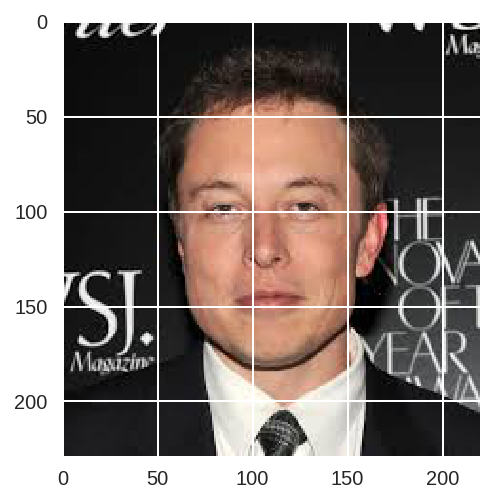

The dog breed corresponding to this humain is Chihuahua


#################################################################################


A HUMAN is Detected


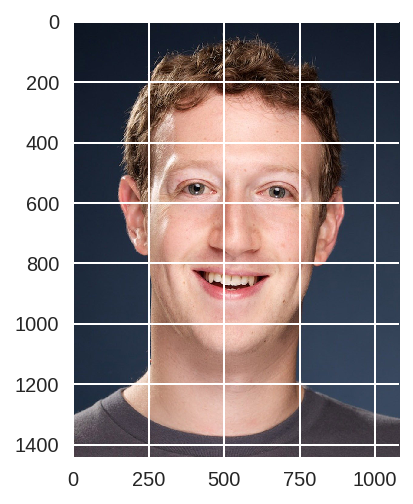

The dog breed corresponding to this humain is Lhasa apso


#################################################################################


A HUMAN is Detected


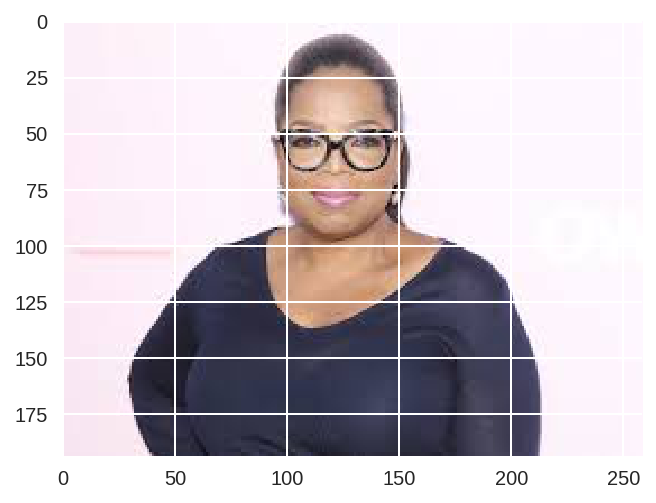

The dog breed corresponding to this humain is Dachshund


#################################################################################


A HUMAN is Detected


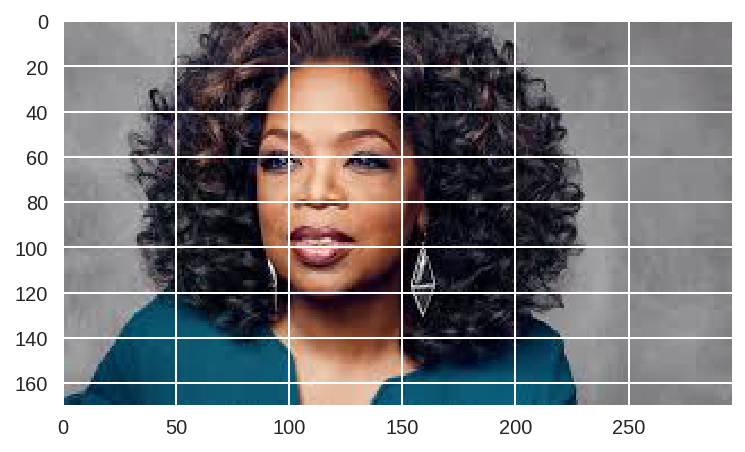

The dog breed corresponding to this humain is English cocker spaniel


#################################################################################


A HUMAN is Detected


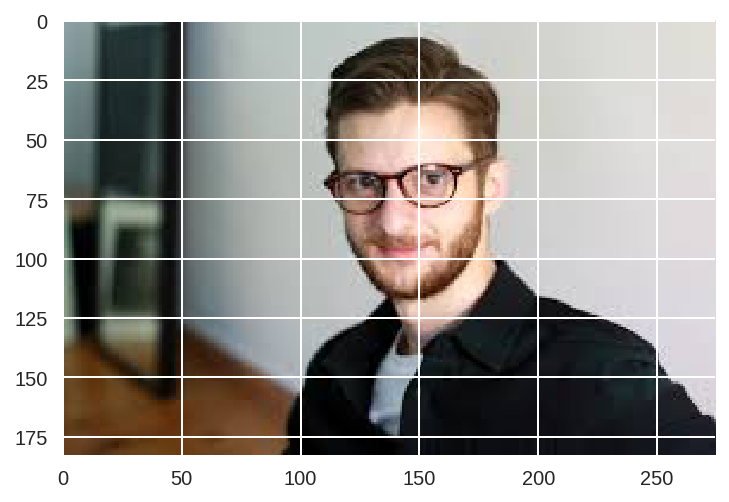

The dog breed corresponding to this humain is Bearded collie


#################################################################################


A DOG is Detected


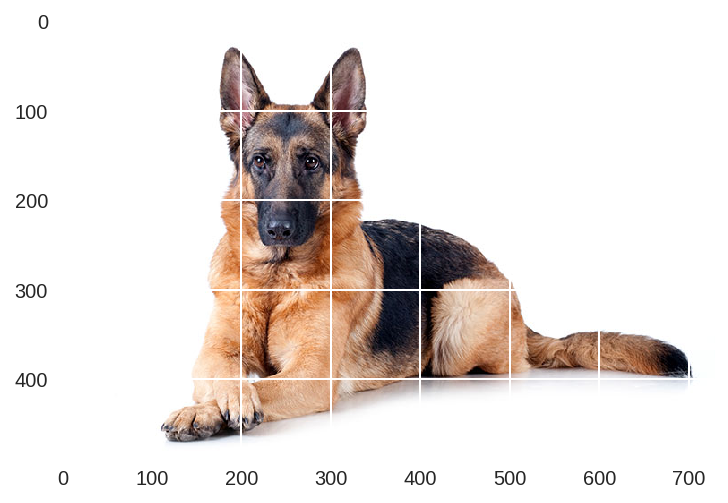

The dog breed is probably German shepherd dog


#################################################################################


A DOG is Detected


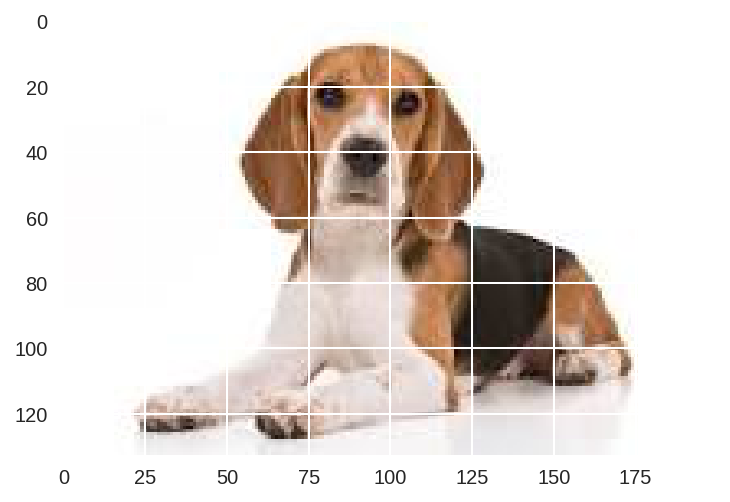

The dog breed is probably Beagle


#################################################################################


A DOG is Detected


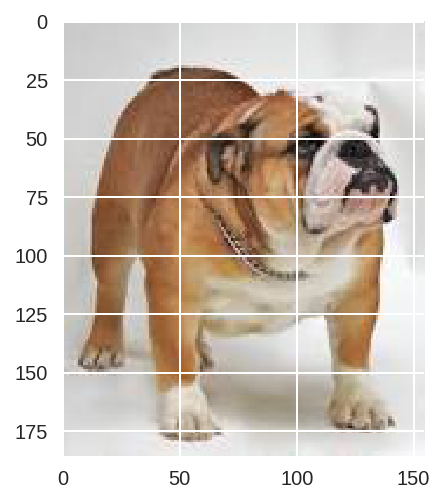

The dog breed is probably Bulldog


#################################################################################


A DOG is Detected


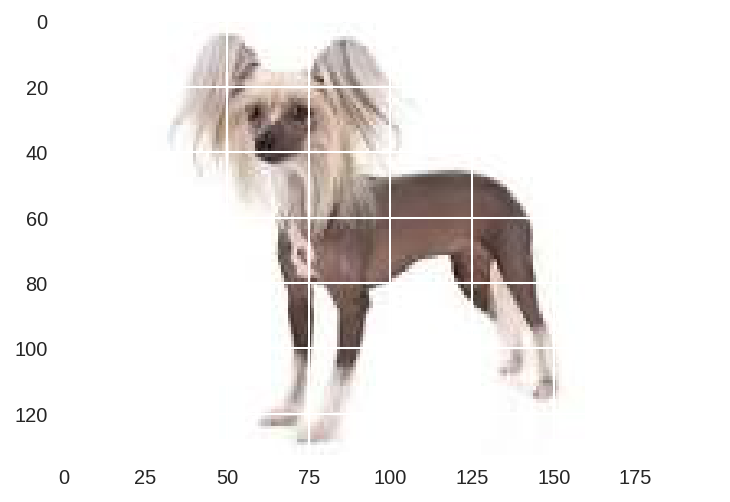

The dog breed is probably Chinese crested


#################################################################################


A DOG is Detected


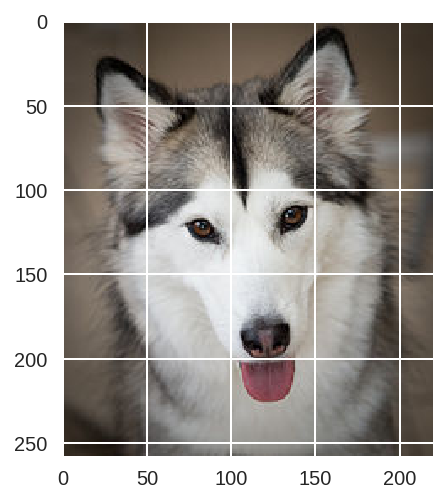

The dog breed is probably Alaskan malamute


#################################################################################




In [0]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.

human_files = ['ellon.jpeg', 'mark.jpg', 'oprahglasses.jpeg','oprah.jpeg', 'download.jpeg']
dog_files = ['German-Shepherd-on-White-00.jpg', 'beagle.jpeg', 'bulldog.jpeg', 'chinese.jpeg', 'siberian.jpg' ]
## suggested code, below
for file in np.hstack((human_files[:5], dog_files[:5])):
    run_app(file)
    print('\n')
    print('#################################################################################')
    print('\n')